# Стохастические методы оптимизации

In [1]:
import math
import time
import warnings
from functools import partial
from typing import Callable, Iterator
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## Основная часть (всего 10 баллов)

__Задача 1 (10 баллов).__ Как и в домашней работе про проксимальные/адаптивные методы мы будем обучать нейросеть на CIFAR10. Возможно, некоторые особо внимательные граждане догадались, что уже в ней мы использовали стохастические методы, ведь подсчет градиента делался по батчу картинок и меток, а не по всему датасету. Однако, из-за адаптивной структуры алгоритмов, они показывали хорошую сходимость. Проверим, будет ли это верно для НЕадаптивных стохастических методов.

Files already downloaded and verified
Files already downloaded and verified
len(cifar_train_dataset)=45001
len(cifar_test_dataset)=9001


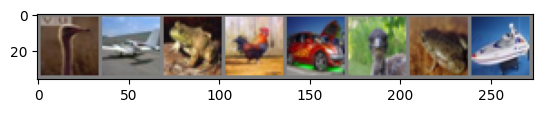

bird  plane frog  bird  car   bird  frog  ship 


In [3]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

cifar_train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar_transform
)



cifar_test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar_transform
)

cifar_ratio = 0.9

cifar_train_dataset, _ = random_split(
    cifar_train_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)

cifar_test_dataset, _ = random_split(
    cifar_test_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)

print(f"{len(cifar_train_dataset)=}")
print(f"{len(cifar_test_dataset)=}")

cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train_dataset, batch_size=128, shuffle=True
)

cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test_dataset, batch_size=128, shuffle=False
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

def imshow(image):
    image = image / 2 + 0.5
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()

images, labels = next(iter(cifar_train_loader))
images, labels = images[:8], labels[:8]
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

__а) (0.5 балла)__ В отличие от предыдущей легковесной модели, в данной домашней работе будет предложена к рассмотрению более тяжелая ```VGG16```. Архитектура сети состоит из 5ти сверточных блоков, 1го усредняющего пулинга и 1го классификатора на основе линейных слоев с дропаутом. Описание блоков (```in``` - размер входа, ```out```- размер выхода):

Сверточный блок (таких 5: [in=3, out=64], [in=64, out=128], [in=128, out=256], [in=256, out=512], [in=512, out=512]): 
1. ```Conv2d(in=in, out=out, kernel=3, padding=1)```
2. ```BatchNorm2d(out)```
3. ```ReLU(inplace=True)```
4. ```Conv2d(in=out, out=out, kernel_size=3, padding=1)```
5. ```BatchNorm2d(out)```
6. ```ReLU(inplace=True)```
7. ```MaxPool2d(kernel_size=2, stride=2)```

Пулинг слой:

1. ```AdaptiveAvgPool2d((7, 7))```

Классификатор:

1. ```Linear(512 * 7 * 7, 4096)```
2. ```ReLU(inplace=True)```
4. ```Linear(4096, 4096)```
5. ```ReLU(inplace=True)```
6. ```Linear(4096, 10)```

```forward``` функция:

1. Свертка поочердено каждым из пяти сверточных блоков;
2. Пулинг;
3. Перед отправкой в классификатор делаем векторизацию с помощью ```flatten``` и используем классификатор.


_Примечание_: Подумайте, почему в классификатор подается именно это число каналов (512 * 7 * 7). Возможно, полезно будет разобраться с функциями пулинга (на будущее). 

В качестве проверки используйте функцию ```print_model_summary```, число параметров должно быть равно 134,309,962.

__Если не ошибаюсь, у вас ошибка --- кол-во параметров всё-таки 128,997,706. У вас в списке слоёв в свёрточных блоках с 3 по 5 лишний раз повторяется conv-batchnorm-relu, в итоге кол-во слоёв на 9 больше, чем должно быть.__

In [4]:
class CifarNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CifarNet, self).__init__()
        self.features = nn.Sequential(
            # Convolution Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolution Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolution Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolution Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Average Pooling Layer
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully Connected Layers (Classificator)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
def print_model_summary(model, input_size):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)
            
            m_key = f"{class_name}-{module_idx+1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters())
            }
            
        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and module != model:
            hooks.append(module.register_forward_hook(hook))

    summary = {}
    hooks = []

    model.apply(register_hook)
    
    with torch.no_grad():
        model(torch.zeros(1, *input_size))

    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")

    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")

    total_params = 0

    for layer in summary:
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"])
        )

        total_params += summary[layer]["nb_params"]

        print(line_new)

    print("================================================================")
    print(f"Total params: {total_params:,}")
    print("----------------------------------------------------------------")


model = CifarNet()
print_model_summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 32, 32]           1,792
       BatchNorm2d-2            [1, 64, 32, 32]             128
              ReLU-3            [1, 64, 32, 32]               0
            Conv2d-4            [1, 64, 32, 32]          36,928
       BatchNorm2d-5            [1, 64, 32, 32]             128
              ReLU-6            [1, 64, 32, 32]               0
         MaxPool2d-7            [1, 64, 16, 16]               0
            Conv2d-8           [1, 128, 16, 16]          73,856
       BatchNorm2d-9           [1, 128, 16, 16]             256
             ReLU-10           [1, 128, 16, 16]               0
           Conv2d-11           [1, 128, 16, 16]         147,584
      BatchNorm2d-12           [1, 128, 16, 16]             256
             ReLU-13           [1, 128, 16, 16]               0
        MaxPool2d-14             [1, 12

Так как это последнее задание, то устроим расчилловочную. Вот функции обучения и валидации, которые нужно было реализовать в домашке про адаптивные методы.

In [6]:
def train_cifar(
    model: nn.Module, optimizer: torch.optim.Optimizer, **loss_kwargs
) -> None:

    train_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for inputs, labels in cifar_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        train_loss += loss.item()
        loss.backward(**loss_kwargs)
        optimizer.step()
        
    return train_loss

def eval_cifar(model: nn.Module) -> tuple[float, float]:
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        
        model.eval()
        for inputs, labels in cifar_test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            val_loss += loss_fn(outputs, labels).item()

    return val_loss, correct / total

Функцию логирования при обучении берем из задания по адаптивным методам.

In [7]:
def check_optimizers_cifar(
    optimizers: list[tuple[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]]],
    epochs: int = 20,
    model_class: Callable[[], nn.Module] = CifarNet,
    train_fn = train_cifar,
    eval_fn = eval_cifar,
) -> dict:

    results_dict = {}

    for name, optimizer_lambda in optimizers:

        train_losses = []
        test_losses = []
        accuracies = []
        time_logs = []

        torch.manual_seed(420)
        
        model = model_class().to(DEVICE)
        optimizer = optimizer_lambda(model.parameters())
        loss, accuracy = eval_fn(model)
        
        test_losses.append(loss)
        accuracies.append(accuracy)
        time_logs.append(0)

        torch.cuda.synchronize()
        start_time = time.time()

        with tqdm(range(epochs), desc=name) as loop:
            for _ in loop:
                
                # train
                train_loss = train_fn(model, optimizer, create_graph=True)
                train_losses.append(train_loss)

                # eval
                eval_loss, accuracy = eval_fn(model)
                accuracies.append(accuracy)
                test_losses.append(eval_loss)

                # log
                torch.cuda.synchronize()
                time_logs.append(time.time() - start_time)
                
                loop.set_postfix({"Loss": eval_loss, "Accuracy": accuracy})

        results_dict[name] = {
            "Epoch": list(range(epochs)),
            "Time": time_logs,
            "Train Loss": train_losses,
            "Accuracy": accuracies,
            }

    return results_dict

__б) (3 балла)__ Теперь, используя понимание того, как работают стохастические методы, реализуйте метод ```SGD```, с возможностью использования момента ```momentum``` (обычного и нестеровского) и $L_2$ регуляризации (он же ```weight_decay```). 

**Псевдокод алгоритма**

_Инициализация:_

Величина шага $\{ \gamma_k \}_{k=0} > 0$, момент $\tau \geq 0$ , регуляризатор $\lambda$, в случае настеровского ускорения $y^0 = 0$. 

$k \hspace{-0.5em}$ _--ая итерация:_

__HeavyBall momentum__
1. Подсчитать стохастический градиент по i-му случайному батчу (при использовании dataloader с ```shuffle=True``` батч берется случайно без повторений) $$g_{k + 1} = \nabla f_i(x^k). $$
2. Добавить регуляризацию $$g_{k + 1} = g_{k + 1} + \lambda x_k.$$
3. Обновить градиент согласно моменту и сделать шаг алгоритма:
$$x^{k+1} = x^k - \gamma_k g_{k + 1} + \tau_k (x^k - x^{k-1}).$$

__Nesterov momentum__
1. Подсчитать стохастический градиент по i-му случайному батчу $$g_{k + 1} = \nabla f_i(y^k). $$
2. Добавить регуляризацию $$g_{k + 1} = g_{k + 1} + \lambda x_k.$$
3. Сделать шаг алгоритма: $$x^{k + 1} = y^k - \gamma g_{k + 1}.$$
3. Обновить переменную скорости $y$:
$$y^{k+1} = x^{k + 1} + \tau (x^{k + 1}- x^k).$$

In [8]:
from torch.optim import Optimizer

class SGD(Optimizer):
    """Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
    """

    def __init__(self, params, lr=1e-3, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        super(SGD, self).__init__(params, defaults)

        self._momentum_buffers = {}

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            # Ваше решение
            lr = group['lr']
            momentum = group['momentum']
            weight_decay = group['weight_decay']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if weight_decay != 0:
                    grad = grad.add(weight_decay, p.data)

                if p not in self._momentum_buffers:
                    self._momentum_buffers[p] = torch.zeros_like(p.data)

                velocity = self._momentum_buffers[p]

                if nesterov:
                    y = p.data - momentum * velocity
                    grad = p.grad.data
                    if weight_decay != 0:
                        grad = grad.add(weight_decay, p.data)

                    p.data = y - lr * grad

                    velocity.mul_(momentum).add_(grad, alpha=1 - dampening)

                else:
                    grad = p.grad.data
                    if weight_decay != 0:
                        grad = grad.add(weight_decay, p.data)

                    p.data = p.data - lr * grad + momentum * velocity

                    velocity.mul_(momentum).add_(grad)
            
        return loss

__д) (1.5 балла)__ У ```SGD``` есть один крупный недостаток - если мы выберем шаг постоянным, то можем осциллировать около точки оптимума, начиная с какого-то шага (из-за наличия дисперсионного члена), а хотелось бы все-таки к ней сойтись. Поэтому предлагается рассмотреть несколько скедулеров (от английского schedule - график/расписание), которые будут менять размер шага в зависимости от номера итерации. Для начала, немного изменим функцию ```check_optimizers```, чтобы она могла работать со скедулерами (по умолчанию поставим оптимизатором ```SGD```, однако вы можете переписать функцию, чтобы она принимала также и сам оптимизатор). 

In [17]:
def check_schedulers_cifar(
    schedulers: list[tuple[str, Callable[[torch.optim.Optimizer], torch.optim.lr_scheduler.LRScheduler]]],
    model_class: Callable[[], nn.Module] = CifarNet,
    epochs = 20,
    train_fn = train_cifar,
    eval_fn = eval_cifar,
) -> dict:
    
    start_lr = 1e-1
    epochs = 20
    results_dict = {}

    for name, scheduler_lambda, optimizer_lambda in schedulers:
        print(name)
        test_losses = []
        accuracies = []
        lrs = []

        torch.manual_seed(420)
        model = model_class().to(DEVICE)
        optimizer = optimizer_lambda(model.parameters(), lr=start_lr)
        scheduler = scheduler_lambda(optimizer)


        with tqdm(range(epochs), desc=name) as loop:
            for _ in loop:
                # train
                train_loss = train_fn(model, optimizer, create_graph=True)
    
                # eval
                eval_loss, accuracy = eval_fn(model)
                accuracies.append(accuracy)
                test_losses.append(eval_loss)
    
                # log
                torch.cuda.synchronize()
                lrs.append(optimizer.param_groups[0]['lr'])
                
                loop.set_postfix({"Loss": eval_loss, "Accuracy": accuracy})
    
                # scheduler step
                scheduler.step()

        results_dict[name] = {
            "Learning Rate": lrs,
            "Epoch": list(range(epochs)),
            "Test Loss": test_losses,
            "Accuracy": accuracies,
        }

    return results_dict

__е) (3 балла)__ Проверьте работу следующих типов скедулеров: 

0) ```Default```, поставьте шаг равным 1e-1.
1) ```LambdaLR```, где функция от номера эпохи $k$ зависит как $\dfrac{1}{(k + 1)^2}$.
2) ```ExponentialLR```, где шаг на каждой эпохе домнажается на постоянный фактор $\gamma$.
3) ```CosinAnnealingLR```, см. [мануал](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html) торча. Как вам кажется, зачем вообще может использоваться такой скедулер?
4) ```LinearLR```, где шаг линейно убывает с каждой новой эпохой.

Пойстройте графики зависимости ошибки на train, значение accuracy и шага в зависимости от эпохи.

Этот код был написан до того, как я поменял check_schedulers_cifar так, чтобы он мог принимать разные оптимизаторы, из-за этого несоответствие синтаксиса. Первые скедулеры закомментированы потому что после третьего всё упало и пришлось перезапустить, пропустив их (не считать же второй раз).

In [13]:
# Ваше решение
import torch.optim.lr_scheduler as sch
schedulers = [
    # ("Default", lambda optimizer: sch.LambdaLR(optimizer, lr_lambda=lambda epoch: 1.0)),
    # ("LambdaLR", lambda optimizer: sch.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (epoch + 1)**2)),
    # ("ExponentialLR", lambda optimizer: sch.ExponentialLR(optimizer, gamma=0.9)),
    ("CosineAnnealingLR", lambda optimizer: sch.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)),
    ("LinearLR", lambda optimizer: sch.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=20)),
]

# results = []
for s in schedulers:
    results.append(check_schedulers_cifar([s]))



CosineAnnealingLR


CosineAnnealingLR: 100%|██████████| 20/20 [08:35<00:00, 25.80s/it, Loss=61.9, Accuracy=0.86] 

LinearLR



LinearLR: 100%|██████████| 20/20 [08:22<00:00, 25.14s/it, Loss=62.7, Accuracy=0.86] 


In [14]:
print(len(results))

5


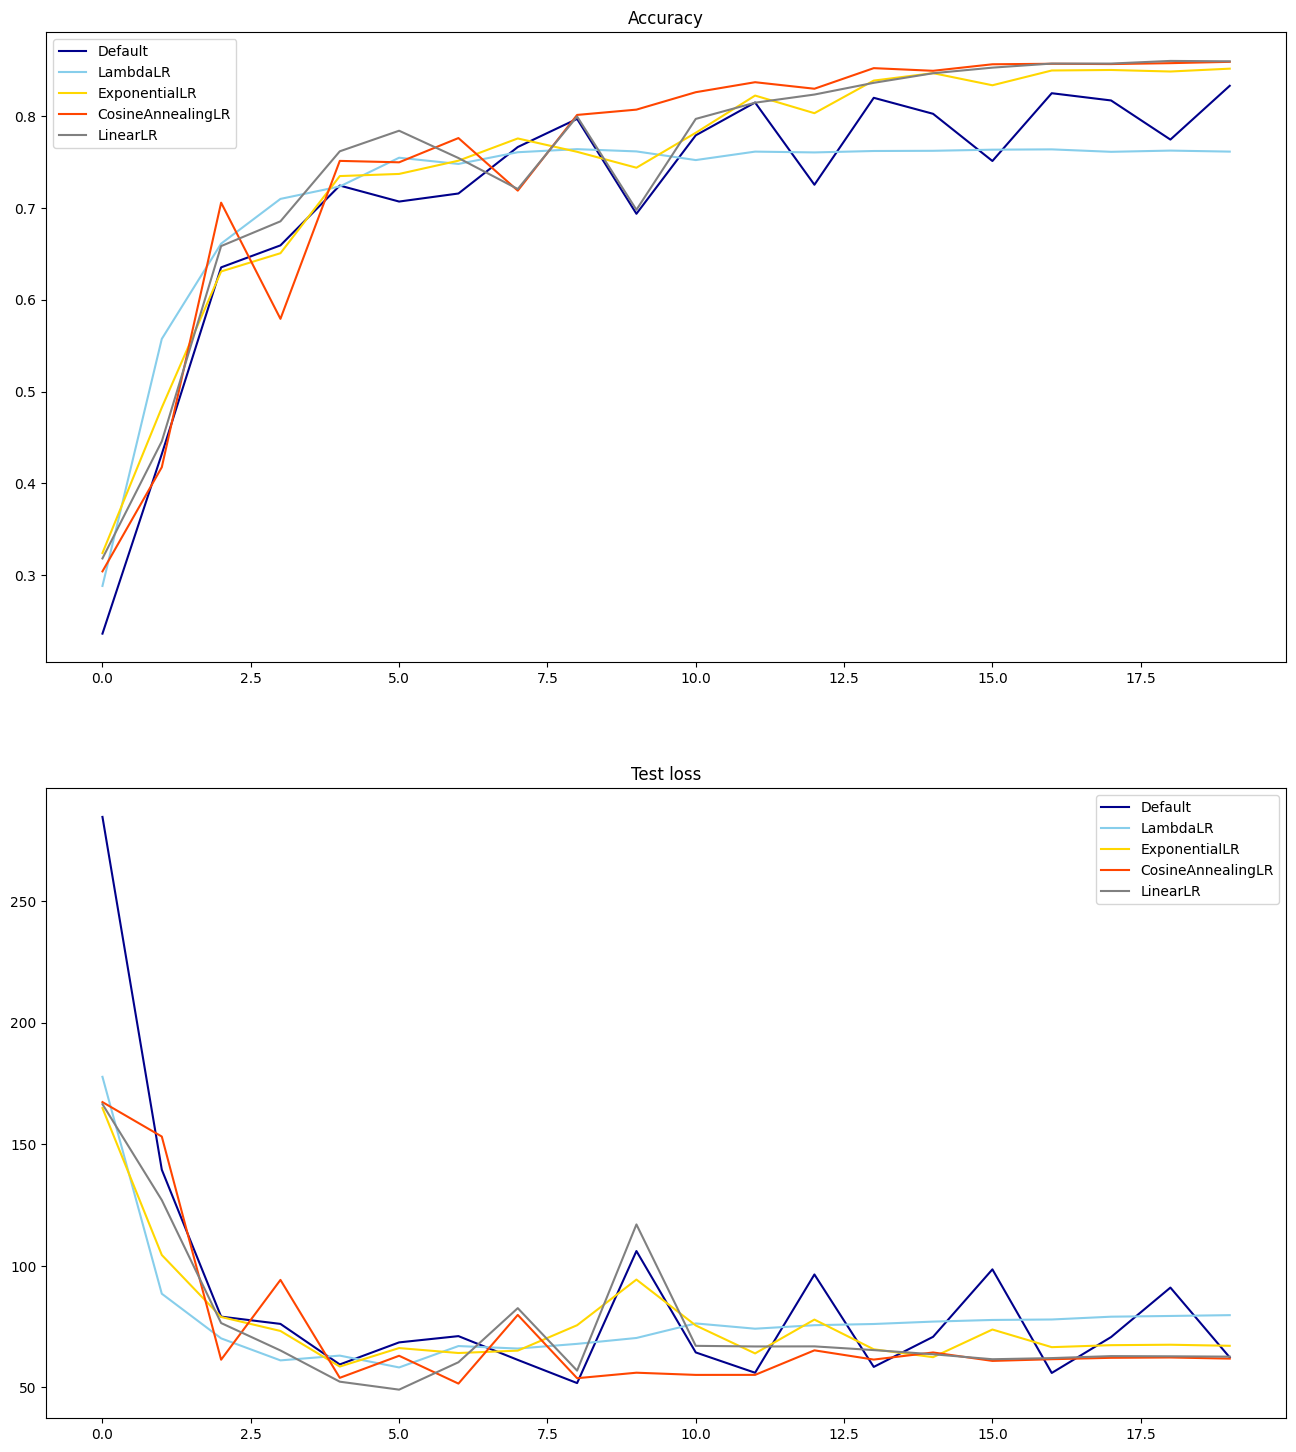

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(16, 18))

ax[0].plot(results[0]["Default"]["Epoch"], results[0]["Default"]["Accuracy"], color="darkblue", label="Default")
ax[0].plot(results[1]["LambdaLR"]["Epoch"], results[1]["LambdaLR"]["Accuracy"], color="skyblue", label="LambdaLR")
ax[0].plot(results[2]["ExponentialLR"]["Epoch"], results[2]["ExponentialLR"]["Accuracy"], color="gold", label="ExponentialLR")
ax[0].plot(results[3]["CosineAnnealingLR"]["Epoch"], results[3]["CosineAnnealingLR"]["Accuracy"], color="orangered", label="CosineAnnealingLR")
ax[0].plot(results[4]["LinearLR"]["Epoch"], results[4]["LinearLR"]["Accuracy"], color="gray", label="LinearLR")

ax[1].plot(results[0]["Default"]["Epoch"], results[0]["Default"]["Test Loss"], color="darkblue", label="Default")
ax[1].plot(results[1]["LambdaLR"]["Epoch"], results[1]["LambdaLR"]["Test Loss"], color="skyblue", label="LambdaLR")
ax[1].plot(results[2]["ExponentialLR"]["Epoch"], results[2]["ExponentialLR"]["Test Loss"], color="gold", label="ExponentialLR")
ax[1].plot(results[3]["CosineAnnealingLR"]["Epoch"], results[3]["CosineAnnealingLR"]["Test Loss"], color="orangered", label="CosineAnnealingLR")
ax[1].plot(results[4]["LinearLR"]["Epoch"], results[4]["LinearLR"]["Test Loss"], color="gray", label="LinearLR")

ax[0].set_title("Accuracy")
ax[1].set_title("Test loss")
ax[0].legend()
ax[1].legend()

pass

__ё) (2 балла)__ Теперь посмотрим на зависимость обучения от размера батча. Для этого необходимо создать несколько даталоадеров с разными параметрами ```batch_size``` и обучить модель на них. Для валидации оставьте размер неизменным. Предлагается рассмотреть следующие размеры: 32, 64, 128, 256. Что можно сказать о качестве обучения в зависимости от размера батча?

_Указание_: Подумайте, почему при уменьшении батча время обучения увеличивается? Ведь мы прокидываем градиент по меньшему числу элементов датасета, все должно работать быстрее. (может не работать при малом количестве графической памяти на устройстве)

In [ ]:
# Ваш решение

В этот раз решил даже сделать дополнительную часть

## Дополнительная часть (всего 10 баллов)

__Задача 1 (10 баллов).__ Методы с редукцией дисперсии крайне неудобны для использования с библиотекой ```torch.optim```, так как используют внутри себя знания про полный градиент, который почти никогда нельзя честно посчитать из-за невозможности подгрузить весь датасет на графический процессор. Однако, есть небольшое семейство методов, которые не используют подсчет полного градиента.

__а) (7 баллов)__  В этом задании вы попробуете реализовать метод с редукцией дисперсии ```SARAH``` из работы [Random-reshuffled SARAH does not need full gradient computations](https://arxiv.org/html/2111.13322v2):

**Псевдокод алгоритма**

_Инициализация:_

Величина шага $\{ \gamma_k \}_{k=0} > 0$, регуляризатор $\lambda$, переменная $v^0 = 0$. 

$k \hspace{-0.5em}$ _--ая итерация:_

1. Подсчитать стохастический градиент по i-му случайному батчу (при использовании dataloader с ```shuffle=True``` батч берется случайно без повторений) $$g_{k + 1} = \nabla f_i(x^k). $$
2. Добавить регуляризацию $$g_{k + 1} = g_{k + 1} + \lambda x_k.$$
3. Обновить переменную $$v^{k + 1} =  g_{k + 1} - g_k + v^{k}.$$

_Уточнение_. Здесь $g_k = \nabla f_i(x^{k - 1})$, то есть батч отстается тем же, но параметры берутся из предыдущей эпохи.
3. Сделать шаг:
$$x^{k+1} = x^k - \gamma_k v^{k + 1}.$$

Стоит также отметить, что у данного алгоритма есть небольшой нюанс - он смещенный, то есть сходимость будет не точно к значению глобального минимума. Но в случае больших нейронных сетей это не очень важно.

In [36]:
from torch.optim.optimizer import Optimizer, required

class SARAH(Optimizer):
    r"""Implements SARAH
    """
    def __init__(self, params, lr=1e-2, weight_decay=0):

        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SARAH, self).__init__(params, defaults)
        
        # Дополните необходимыми параметрами (необязательно)
        self._prevs = {} # хранит предыдущие градиенты
        self._v = {}

    def __setstate__(self, state):
        super(SARAH, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            # Ваше решение 
            lr = group['lr']
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                
                if weight_decay != 0:
                    grad = grad.add(weight_decay, p.data)

                if p not in self._prevs:
                    self._prevs[p] = torch.zeros_like(p.data)
                    self._v[p] = torch.zeros_like(p.data)

                prev_grad = self._prevs[p]
                v = self._v[p]
                
                # print(grad.shape, prev_grad.shape, v.shape)
                
                v = grad - prev_grad + v
                self._prevs[p] = grad
                self._v[p] = v

                p.data = p.data - lr * v
            
        return loss

__б) (3 балла)__ Постройте сравнительные графики с лучшими параметрами для рассмотренных методов. Включите также в рассмотрение ```torch.optim.SGD``` с параметрами, аналогичными реализованному ```SGD```. Вы также можете добавить скедулеры и оценить их влияние на результат. 

В качестве скедулера возьму только LinearLR

In [37]:
# Ваше решение


optimizers = [
    # ("SGD", lambda optimizer: sch.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=20),
    #  lambda params, lr: SGD(params, lr=lr)),
    ("SARAH", lambda optimizer: sch.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=20),
     lambda params, lr: SARAH(params, lr=lr)),
    ("torch.optim.sgd", lambda optimizer: sch.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=20),
     lambda params, lr: torch.optim.SGD(params, lr=lr))
]

# extra_results = []
for s in optimizers:
    extra_results.append(check_schedulers_cifar([s]))

SARAH


SARAH: 100%|██████████| 20/20 [08:26<00:00, 25.33s/it, Loss=65.2, Accuracy=0.856]

torch.optim.sgd



torch.optim.sgd: 100%|██████████| 20/20 [08:05<00:00, 24.28s/it, Loss=66.5, Accuracy=0.856]


In [38]:
print(len(extra_results))

3


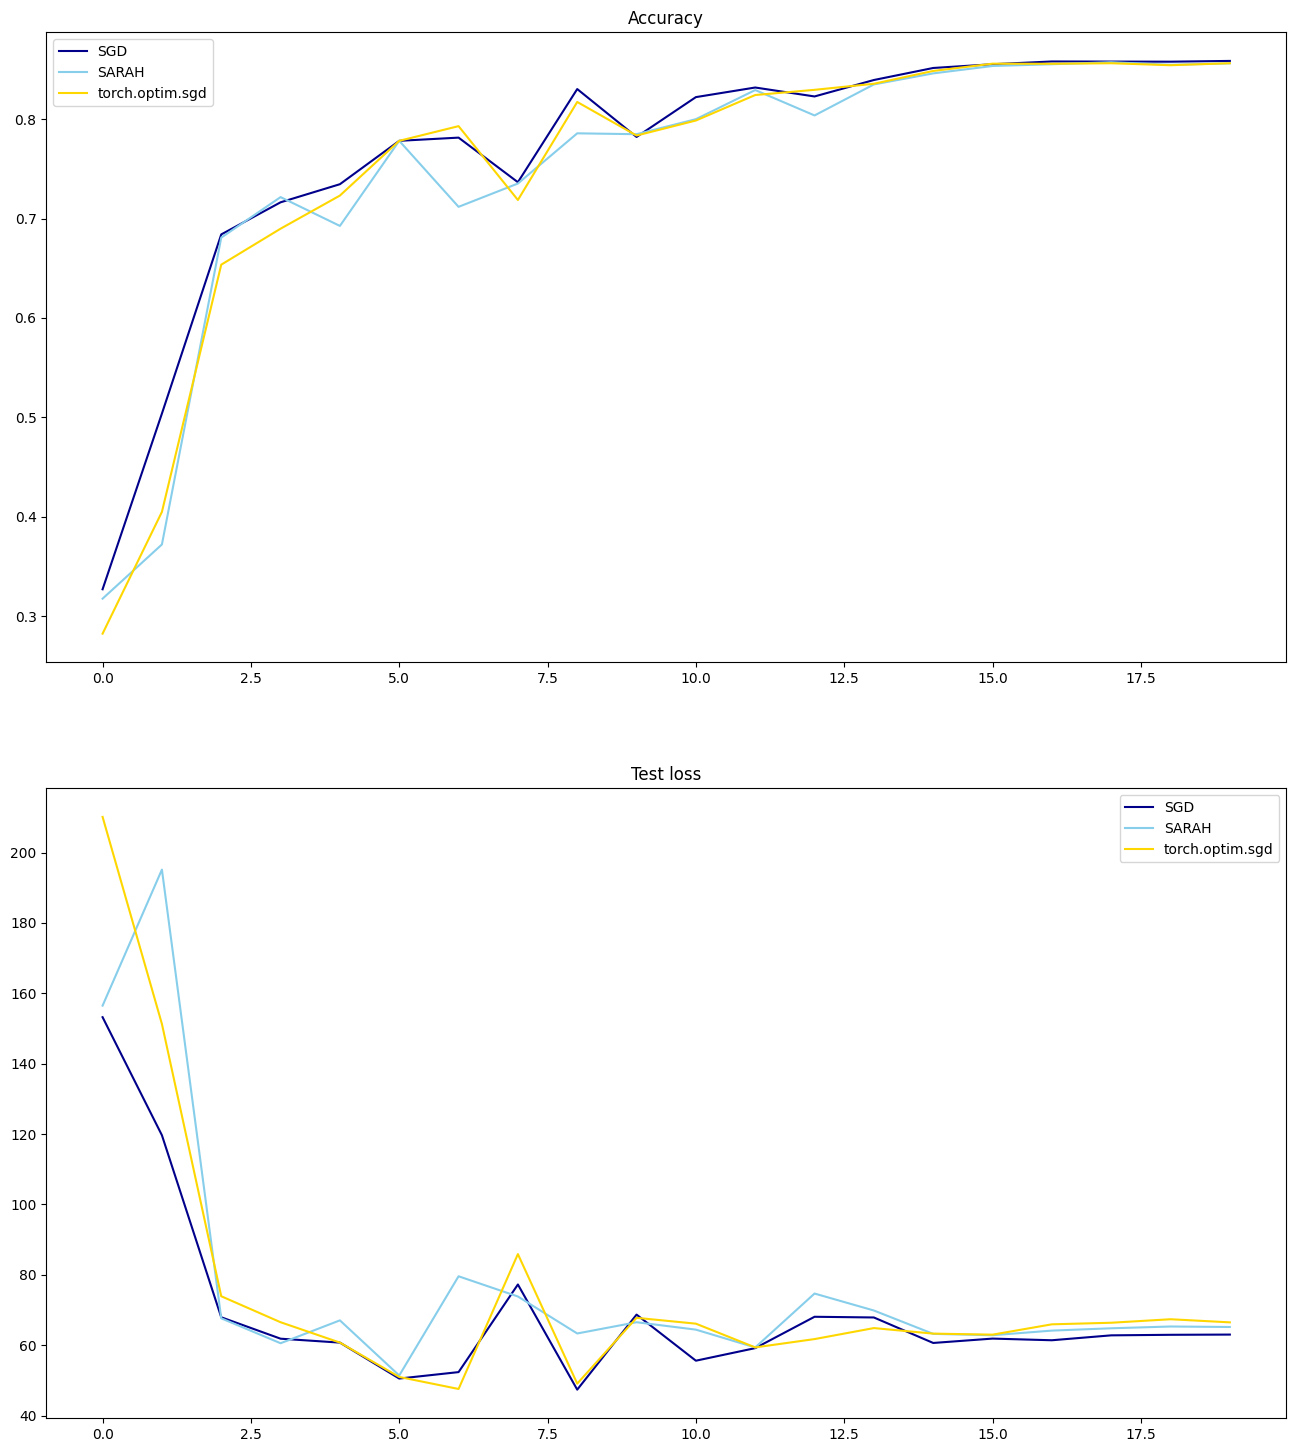

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(16, 18))

ax[0].plot(extra_results[0]["SGD"]["Epoch"], extra_results[0]["SGD"]["Accuracy"], color="darkblue", label="SGD")
ax[0].plot(extra_results[1]["SARAH"]["Epoch"], extra_results[1]["SARAH"]["Accuracy"], color="skyblue", label="SARAH")
ax[0].plot(extra_results[2]["torch.optim.sgd"]["Epoch"], extra_results[2]["torch.optim.sgd"]["Accuracy"], color="gold", label="torch.optim.sgd")

ax[1].plot(extra_results[0]["SGD"]["Epoch"], extra_results[0]["SGD"]["Test Loss"], color="darkblue", label="SGD")
ax[1].plot(extra_results[1]["SARAH"]["Epoch"], extra_results[1]["SARAH"]["Test Loss"], color="skyblue", label="SARAH")
ax[1].plot(extra_results[2]["torch.optim.sgd"]["Epoch"], extra_results[2]["torch.optim.sgd"]["Test Loss"], color="gold", label="torch.optim.sgd")

ax[0].set_title("Accuracy")
ax[1].set_title("Test loss")
ax[0].legend()
ax[1].legend()

pass